### Download Data

The data is taken from http://archive.ics.uci.edu/ml/machine-learning-databases/00240/, but you can have it in the form of the UCI-HAR-Dataset.zip.

Extract it to the folder of your notebook with the solution (or suitably adjust the paths to training and test data specified below (TRAIN, TEST).  

Spcifically, the split into training and testing data is already done. The dataset contains 7352 training and 2947 test samples.  

Each sample consists of nine timeseries of float values, each of length 128.

The nine timeseries are collected by an accelerometer and a gyroscope that contain information about the motion and the orientation, respectively.

In [1]:
import os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

### Load Data

In [2]:
# Useful Constants
TRAIN = "UCI_HAR_Dataset/train/"
TEST = "UCI_HAR_Dataset/test/"

# x-values, 'signals'
# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]
X_train_signals_paths = [TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES]
X_test_signals_paths =  [TEST  + "Inertial Signals/" + signal + "test.txt"  for signal in INPUT_SIGNAL_TYPES]


# y-values, 'labels'
#Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]
N_CLASSES = len(LABELS)
y_train_path = TRAIN + "y_train.txt"
y_test_path  = TEST  + "y_test.txt"

In [3]:
# Load "X" (the neural network's training and testing inputs)
def load_X(X_signals_paths):
    X_signals = []
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
print(X_train.shape, X_test.shape)

(7352, 128, 9) (2947, 128, 9)


In [4]:
# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

def one_hot(y, n_classes):
    y = y.reshape(len(y))
    return np.eye(n_classes)[np.array(y, dtype=np.int32)]

def label_from_onehot(vectors):
    indices = []
    for vector in vectors:
        indices.append(np.argmax(vector))
    return np.array(indices)

Y_train = one_hot(load_y(y_train_path), N_CLASSES)
Y_test = one_hot(load_y(y_test_path), N_CLASSES)
print(Y_train.shape, Y_test.shape)

(7352, 6) (2947, 6)


#### Plot some samples

In [5]:
X_train_per_class = {}
for c in range(N_CLASSES):
    mask = label_from_onehot(Y_train)==c
    X_train_per_class[c] = X_train[mask]

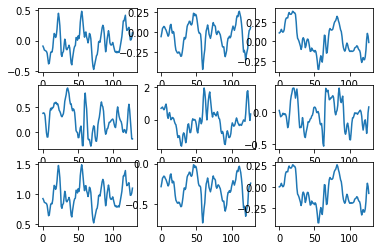

In [6]:
def plot_lines(X, nsamples):
    t = range(128)
    for i in range(9):
        plt.subplot(3,3,i+1)
        for j in range(np.minimum(X.shape[0],nsamples)):
            plt.plot(t,X[j,:,i])
    plt.show()
    
plot_lines(X_train_per_class[1], 1)

In [7]:
# Input Data
training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
means = np.mean(X_train, axis=(0,1))
stdevs = np.std(X_train, axis=(0,1))

print("X shape, Y_shape:")
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)
print()
print("Mean / Stdev for each feature:")
for i in range(9):
    print("%7.4f | %7.4f"%(means[i], stdevs[i]))

X shape, Y_shape:
(7352, 128, 9) (7352, 6)
(2947, 128, 9) (2947, 6)

Mean / Stdev for each feature:
-0.0006 |  0.1948
-0.0003 |  0.1224
-0.0003 |  0.1069
 0.0005 |  0.4068
-0.0008 |  0.3819
 0.0001 |  0.2557
 0.8047 |  0.4141
 0.0288 |  0.3910
 0.0865 |  0.3578


### Normalization

Can be skipped since the features are all at similar scales aready.

### Utilities

In [8]:
def performance_plots(model, X_test, Y_test, log, epochs):    
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (end):', acc[-1])
    print('Train accuracy (max):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (max) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [9]:
import sklearn
from sklearn import metrics
import pandas as pd
activities = ["walk", "up", "down", "sit", "stand", "lay"]

def confusion_matrix(model, X_test, Y_test):
    scores = model.predict(X_test)
    predictions = np.argmax(scores, axis=1)
    labels = np.argmax(Y_test, axis=1)
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({activities[i] : cm[:,i] for i in range(len(activities))}, activities)
    return df

## Specify and Train Models

Try different architectures to solve the activity recognition problem.

At minimum implement
* Model with a single layer of SimpleRNN
* Model with several layers of SimpleRNNs
* Model with several CNN layers
* Mixed model with several layers of CNNs, then its output model with 1+ layers of SimpleRNNs

Try with different number of units.

Report about your findings.

In [78]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Conv1D, Flatten, MaxPooling1D, Dropout, Reshape, Conv2D, Input, MaxPooling2D

### Single Layer SimpleRNN

In [11]:
### START YOUR CODE

model = Sequential([
    SimpleRNN(units=512, input_shape=(None, 9), return_sequences=False, activation='tanh', kernel_initializer='glorot_uniform'),
    Dense(units=6, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001), metrics="accuracy")

### END YOUR CODE

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 512)               267264    
_________________________________________________________________
dense (Dense)                (None, 6)                 3078      
Total params: 270,342
Trainable params: 270,342
Non-trainable params: 0
_________________________________________________________________


In [12]:
### START YOUR CODE
batch_size = 32
n_epochs   = 10

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/10
230/230 [==============================] - 130s 567ms/step - loss: 1.0502 - accuracy: 0.5596 - val_loss: 1.0307 - val_accuracy: 0.5660
Epoch 2/10
230/230 [==============================] - 91s 395ms/step - loss: 0.8953 - accuracy: 0.6313 - val_loss: 0.9318 - val_accuracy: 0.6223
Epoch 3/10
230/230 [==============================] - 83s 359ms/step - loss: 0.6670 - accuracy: 0.7209 - val_loss: 0.7961 - val_accuracy: 0.6956
Epoch 4/10
230/230 [==============================] - 82s 356ms/step - loss: 0.5239 - accuracy: 0.8014 - val_loss: 0.6621 - val_accuracy: 0.7825
Epoch 5/10
230/230 [==============================] - 82s 358ms/step - loss: 0.5528 - accuracy: 0.8320 - val_loss: 0.5381 - val_accuracy: 0.7998
Epoch 6/10
230/230 [==============================] - 82s 358ms/step - loss: 0.4213 - accuracy: 0.8629 - val_loss: 0.9099 - val_accuracy: 0.6994
Epoch 7/10
230/230 [==============================] - 83s 360ms/step - loss: 0.3649 - accuracy: 0.8781 - val_loss: 0.5026 - val_a

Train accuracy (end): 0.6349292993545532
Train accuracy (max): 0.9008433222770691
Test accuracy (end) : 0.6111299395561218
Test accuracy (max) : 0.8652867078781128


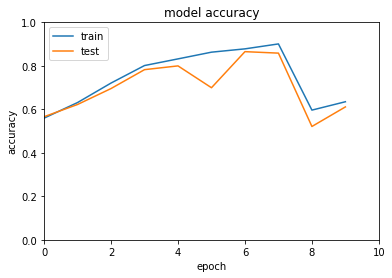

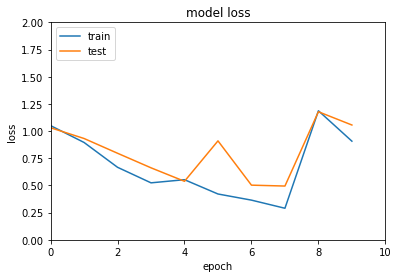

,walk,up,down,sit,stand,lay
walk,140,75,34,80,167,0
up,40,258,25,21,126,1
down,103,47,117,52,101,0
sit,2,19,0,293,177,0
stand,6,11,1,29,485,0
lay,0,29,0,0,0,508


In [13]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings

This simple model already achieved a test accuracy of 86.5% at max. After the 7th epoch the training seems to have collapsed which is most probably due to an exploding gradient problem as the used sequence is quite long (`128` steps).

### Stacked Simple RNNs

In [14]:
### START YOUR CODE

model = Sequential([
    SimpleRNN(units=256, input_shape=(None, 9), return_sequences=True, activation='tanh', kernel_initializer='glorot_uniform'),
    SimpleRNN(units=512, return_sequences=True, activation='tanh', kernel_initializer='glorot_uniform'),
    SimpleRNN(units=1024, return_sequences=False, activation='tanh', kernel_initializer='glorot_uniform'),
    Dense(units=6, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001), metrics="accuracy")
### END YOUR CODE

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 256)         68096     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 512)         393728    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 1024)              1573888   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6150      
Total params: 2,041,862
Trainable params: 2,041,862
Non-trainable params: 0
_________________________________________________________________


In [15]:
### START YOUR CODE
batch_size = 32
n_epochs   = 10

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/10
230/230 [==============================] - 450s 2s/step - loss: 0.5447 - accuracy: 0.7980 - val_loss: 0.5642 - val_accuracy: 0.8402
Epoch 2/10
230/230 [==============================] - 426s 2s/step - loss: 0.2302 - accuracy: 0.9174 - val_loss: 0.5464 - val_accuracy: 0.8487
Epoch 3/10
230/230 [==============================] - 402s 2s/step - loss: 0.1914 - accuracy: 0.9266 - val_loss: 0.8380 - val_accuracy: 0.7961
Epoch 4/10
230/230 [==============================] - 404s 2s/step - loss: 0.1765 - accuracy: 0.9317 - val_loss: 0.4677 - val_accuracy: 0.8714
Epoch 5/10
230/230 [==============================] - 402s 2s/step - loss: 0.2937 - accuracy: 0.8954 - val_loss: 0.4969 - val_accuracy: 0.8778
Epoch 6/10
230/230 [==============================] - 406s 2s/step - loss: 0.2161 - accuracy: 0.9203 - val_loss: 0.5464 - val_accuracy: 0.8633
Epoch 7/10
230/230 [==============================] - 403s 2s/step - loss: 0.1686 - accuracy: 0.9336 - val_loss: 0.6535 - val_accuracy: 0.8208

Train accuracy (end): 0.9272306561470032
Train accuracy (max): 0.9405604004859924
Test accuracy (end) : 0.8808958530426025
Test accuracy (max) : 0.8870037198066711


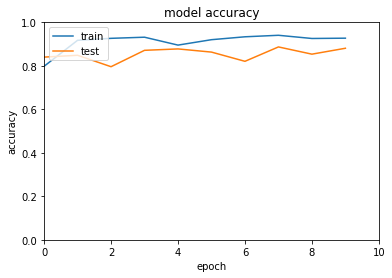

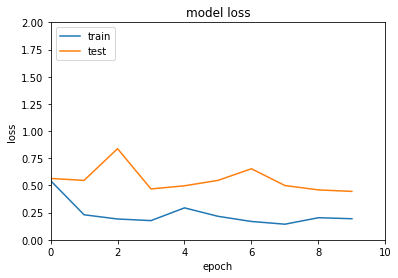

,walk,up,down,sit,stand,lay
walk,451,12,22,1,10,0
up,27,415,24,0,5,0
down,2,27,391,0,0,0
sit,0,10,0,342,139,0
stand,3,1,0,41,487,0
lay,0,27,0,0,0,510


In [16]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings

Using stacked SimpleRNN layers seems to prevent the exploding gradient problem somehow, but this could also be due to a lucky initialization and short training time. The additional layers bring an test accuray improvement and enable a score of 88.7% at max.

### Several CNN Layers

In [17]:
### START YOUR CODE

model = Sequential([
    Conv1D(filters=32, kernel_size=3, input_shape=(128, 9), activation='relu', kernel_initializer='he_normal'),
    Conv1D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    MaxPooling1D(),
    Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    MaxPooling1D(),
    Conv1D(filters=128, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    Conv1D(filters=128, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    MaxPooling1D(),
    Conv1D(filters=256, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    Conv1D(filters=256, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    Flatten(),
    Dense(units=512, activation='relu', kernel_initializer='he_normal'),
    Dense(units=6, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001), metrics="accuracy")
### END YOUR CODE

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 126, 32)           896       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 124, 32)           3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 62, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 60, 64)            6208      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 58, 64)            12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 29, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 27, 128)          

In [18]:
### START YOUR CODE
batch_size = 32
n_epochs   = 10

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/10
230/230 [==============================] - 9s 41ms/step - loss: 0.5462 - accuracy: 0.7922 - val_loss: 0.4912 - val_accuracy: 0.8436
Epoch 2/10
230/230 [==============================] - 9s 41ms/step - loss: 0.1879 - accuracy: 0.9268 - val_loss: 0.4245 - val_accuracy: 0.8578
Epoch 3/10
230/230 [==============================] - 10s 42ms/step - loss: 0.1343 - accuracy: 0.9465 - val_loss: 0.3361 - val_accuracy: 0.8989
Epoch 4/10
230/230 [==============================] - 9s 41ms/step - loss: 0.1000 - accuracy: 0.9565 - val_loss: 0.3963 - val_accuracy: 0.8901
Epoch 5/10
230/230 [==============================] - 10s 45ms/step - loss: 0.0878 - accuracy: 0.9574 - val_loss: 0.3289 - val_accuracy: 0.9114
Epoch 6/10
230/230 [==============================] - 12s 52ms/step - loss: 0.0859 - accuracy: 0.9612 - val_loss: 0.3642 - val_accuracy: 0.8982
Epoch 7/10
230/230 [==============================] - 11s 47ms/step - loss: 0.0839 - accuracy: 0.9623 - val_loss: 0.4429 - val_accuracy: 0.

Train accuracy (end): 0.9684439897537231
Train accuracy (max): 0.9684439897537231
Test accuracy (end) : 0.9141499996185303
Test accuracy (max) : 0.9141499996185303


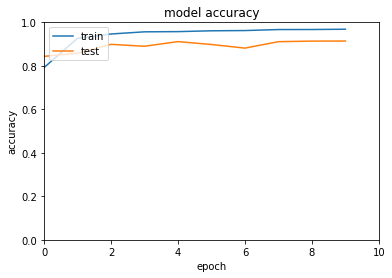

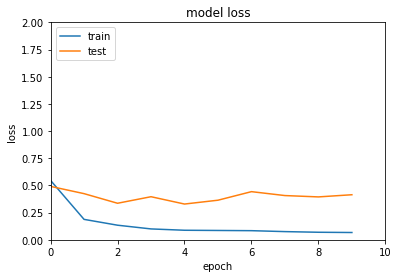

,walk,up,down,sit,stand,lay
walk,482,2,12,0,0,0
up,7,448,16,0,0,0
down,7,5,408,0,0,0
sit,0,4,4,354,129,0
stand,0,3,0,37,492,0
lay,0,27,0,0,0,510


In [19]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings

Training a one dimensional CNN with only a few layers shows a more stable training process. This makes sense because the gradient is not backpropagated through time but "only" through the depth of the network. It achieves the best test accuracy at 91.4%.

### Mixed CNN and RNN

In [87]:
### START YOUR CODE

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer='he_normal', input_shape=(128, 9)),
    Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    MaxPooling1D(),
    Conv1D(filters=128, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    Conv1D(filters=128, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    MaxPooling1D(),
    Conv1D(filters=256, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    Conv1D(filters=256, kernel_size=3, activation='relu', kernel_initializer='he_normal'),
    SimpleRNN(units=64, return_sequences=True, activation='tanh', kernel_initializer='glorot_uniform'),
    SimpleRNN(units=64, return_sequences=True, activation='tanh', kernel_initializer='glorot_uniform'),
    SimpleRNN(units=64, return_sequences=False, activation='tanh', kernel_initializer='glorot_uniform'),
    Flatten(),
    Dense(units=512, activation='relu', kernel_initializer='he_normal'),
    Dense(units=6, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001), metrics="accuracy")
### END YOUR CODE

model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_105 (Conv1D)          (None, 126, 64)           1792      
_________________________________________________________________
conv1d_106 (Conv1D)          (None, 124, 64)           12352     
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 62, 64)            0         
_________________________________________________________________
conv1d_107 (Conv1D)          (None, 60, 128)           24704     
_________________________________________________________________
conv1d_108 (Conv1D)          (None, 58, 128)           49280     
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 29, 128)           0         
_________________________________________________________________
conv1d_109 (Conv1D)          (None, 27, 256)         

In [88]:
### START YOUR CODE
batch_size = 32
n_epochs   = 10

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/10
230/230 [==============================] - 30s 129ms/step - loss: 0.5986 - accuracy: 0.8005 - val_loss: 0.4466 - val_accuracy: 0.8521
Epoch 2/10
230/230 [==============================] - 26s 114ms/step - loss: 0.1684 - accuracy: 0.9404 - val_loss: 0.4149 - val_accuracy: 0.8660
Epoch 3/10
230/230 [==============================] - 26s 113ms/step - loss: 0.1343 - accuracy: 0.9440 - val_loss: 0.4067 - val_accuracy: 0.8850
Epoch 4/10
230/230 [==============================] - 26s 115ms/step - loss: 0.1205 - accuracy: 0.9533 - val_loss: 0.3789 - val_accuracy: 0.8884
Epoch 5/10
230/230 [==============================] - 25s 111ms/step - loss: 0.1052 - accuracy: 0.9567 - val_loss: 0.3820 - val_accuracy: 0.9213
Epoch 6/10
230/230 [==============================] - 26s 114ms/step - loss: 0.0983 - accuracy: 0.9570 - val_loss: 0.4788 - val_accuracy: 0.8867
Epoch 7/10
230/230 [==============================] - 26s 112ms/step - loss: 0.0973 - accuracy: 0.9573 - val_loss: 0.5258 - val_ac

Train accuracy (end): 0.954842209815979
Train accuracy (max): 0.9621871709823608
Test accuracy (end) : 0.9175432920455933
Test accuracy (max) : 0.9212758541107178


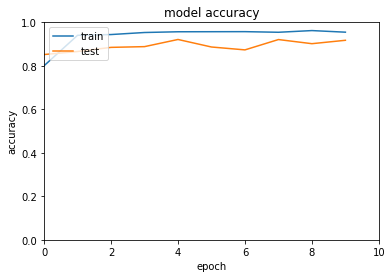

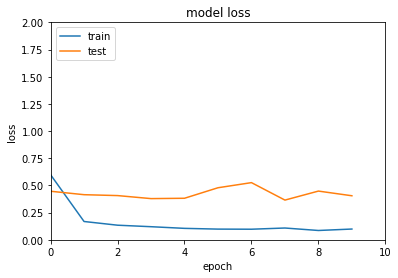

,walk,up,down,sit,stand,lay
walk,460,14,22,0,0,0
up,2,463,6,0,0,0
down,0,10,410,0,0,0
sit,0,25,0,413,53,0
stand,1,3,0,79,449,0
lay,0,28,0,0,0,509


In [89]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings

The combination of 1DCNN layers and and RNN layers seems to be beneficial as the best test accuracy (92.1%) is improved a litte compared to the plain CNN model.

### Several 2D CNN Layers inc Dropout

In [83]:
### START YOUR CODE

dropout_rate = 0.2
start_power = 4
model = Sequential([
    Input(shape=(128, 9)),
    Reshape((128, 9, 1)),
    Conv2D(filters=2**start_power, kernel_size=(3, 1), strides=(2, 1), activation='relu', kernel_initializer='he_normal'),
    Dropout(dropout_rate),
    Conv2D(filters=2**(start_power+1), kernel_size=(3, 1), strides=(2, 1), activation='relu', kernel_initializer='he_normal'),
    Dropout(dropout_rate),
    Conv2D(filters=2**(start_power+2), kernel_size=(3, 1), strides=(2, 1), activation='relu', kernel_initializer='he_normal'),
    Dropout(dropout_rate),
    Conv2D(filters=2**(start_power+3), kernel_size=(3, 1), strides=(2, 1), activation='relu', kernel_initializer='he_normal'),
    Flatten(),
    Dense(units=6, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001), metrics="accuracy")
### END YOUR CODE

model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 128, 9, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 63, 9, 16)         64        
_________________________________________________________________
dropout_55 (Dropout)         (None, 63, 9, 16)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 31, 9, 32)         1568      
_________________________________________________________________
dropout_56 (Dropout)         (None, 31, 9, 32)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 15, 9, 64)         6208      
_________________________________________________________________
dropout_57 (Dropout)         (None, 15, 9, 64)       

In [ ]:
### START YOUR CODE
batch_size = 16
n_epochs   = 200

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/200
460/460 [==============================] - 34s 75ms/step - loss: 0.1084 - accuracy: 0.9517 - val_loss: 0.5778 - val_accuracy: 0.8928
Epoch 2/200
460/460 [==============================] - 33s 73ms/step - loss: 0.0988 - accuracy: 0.9558 - val_loss: 0.3998 - val_accuracy: 0.9094
Epoch 3/200
460/460 [==============================] - 34s 75ms/step - loss: 0.0867 - accuracy: 0.9582 - val_loss: 0.4135 - val_accuracy: 0.9135
Epoch 4/200
460/460 [==============================] - 33s 72ms/step - loss: 0.1015 - accuracy: 0.9558 - val_loss: 0.4361 - val_accuracy: 0.8897
Epoch 5/200
460/460 [==============================] - 34s 75ms/step - loss: 0.0872 - accuracy: 0.9589 - val_loss: 0.4492 - val_accuracy: 0.9026
Epoch 6/200
460/460 [==============================] - 34s 74ms/step - loss: 0.0781 - accuracy: 0.9604 - val_loss: 0.4064 - val_accuracy: 0.9165
Epoch 7/200
460/460 [==============================] - 35s 77ms/step - loss: 0.0804 - accuracy: 0.9597 - val_loss: 0.5117 - val_ac

460/460 [==============================] - 19s 42ms/step - loss: 0.0187 - accuracy: 0.9940 - val_loss: 0.5794 - val_accuracy: 0.8887
Epoch 58/200
460/460 [==============================] - 19s 41ms/step - loss: 0.0146 - accuracy: 0.9944 - val_loss: 0.4893 - val_accuracy: 0.9070
Epoch 59/200
460/460 [==============================] - 19s 41ms/step - loss: 0.0160 - accuracy: 0.9950 - val_loss: 0.5630 - val_accuracy: 0.9033
Epoch 60/200
460/460 [==============================] - 20s 44ms/step - loss: 0.0134 - accuracy: 0.9948 - val_loss: 0.6032 - val_accuracy: 0.9108
Epoch 61/200
460/460 [==============================] - 21s 45ms/step - loss: 0.0121 - accuracy: 0.9969 - val_loss: 0.5795 - val_accuracy: 0.9013
Epoch 62/200
460/460 [==============================] - 22s 47ms/step - loss: 0.0168 - accuracy: 0.9937 - val_loss: 0.4773 - val_accuracy: 0.9125
Epoch 63/200
460/460 [==============================] - 20s 43ms/step - loss: 0.0266 - accuracy: 0.9912 - val_loss: 0.6967 - val_accuracy

460/460 [==============================] - 35s 75ms/step - loss: 6.3222e-07 - accuracy: 1.0000 - val_loss: 0.9520 - val_accuracy: 0.9114
Epoch 113/200
460/460 [==============================] - 35s 76ms/step - loss: 5.0130e-07 - accuracy: 1.0000 - val_loss: 0.9667 - val_accuracy: 0.9111
Epoch 114/200
460/460 [==============================] - 34s 74ms/step - loss: 3.9205e-07 - accuracy: 1.0000 - val_loss: 0.9806 - val_accuracy: 0.9104
Epoch 115/200
460/460 [==============================] - 35s 75ms/step - loss: 3.0636e-07 - accuracy: 1.0000 - val_loss: 0.9959 - val_accuracy: 0.9097
Epoch 116/200
460/460 [==============================] - 36s 78ms/step - loss: 2.3816e-07 - accuracy: 1.0000 - val_loss: 1.0100 - val_accuracy: 0.9108
Epoch 117/200
460/460 [==============================] - 34s 74ms/step - loss: 1.8669e-07 - accuracy: 1.0000 - val_loss: 1.0237 - val_accuracy: 0.9108
Epoch 118/200
460/460 [==============================] - 34s 75ms/step - loss: 1.4578e-07 - accuracy: 1.0000

Train accuracy (end): 1.0
Train accuracy (max): 1.0
Test accuracy (end) : 0.9087207317352295
Test accuracy (max) : 0.9229725003242493


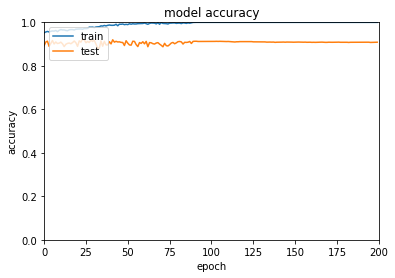

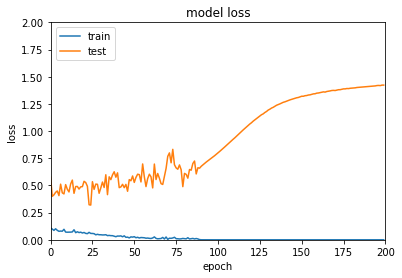

,walk,up,down,sit,stand,lay
walk,469,1,26,0,0,0
up,3,459,9,0,0,0
down,0,3,417,0,0,0
sit,0,27,0,390,74,0
stand,3,1,0,95,433,0
lay,0,27,0,0,0,510


In [92]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings

Using a two dimensional CNN with kernel strictly applied only in the time dimension seems to be superior to a CNN + RNN combination by a tiny margin as it achieves 92.3%. But we must say that the training was done with a much smaller learning rate for many more epochs so this margin might not be that significant.

### Several 2D CNN Layers inc Dropout, with spatial coordinates as channels

In [105]:
### START YOUR CODE

dropout_rate = 0.2
start_power = 5
model = Sequential([
    Input(shape=(128, 9)),
    Reshape((128, 3, 3)),
    Conv2D(filters=2**start_power, kernel_size=(3, 1), strides=(2, 1), activation='relu', kernel_initializer='he_normal'),
    Dropout(dropout_rate),
    Conv2D(filters=2**(start_power+1), kernel_size=(3, 1), strides=(2, 1), activation='relu', kernel_initializer='he_normal'),
    Dropout(dropout_rate),
    Conv2D(filters=2**(start_power+2), kernel_size=(3, 1), strides=(2, 1), activation='relu', kernel_initializer='he_normal'),
    Dropout(dropout_rate),
    Conv2D(filters=2**(start_power+3), kernel_size=(3, 1), strides=(2, 1), activation='relu', kernel_initializer='he_normal'),
    Flatten(),
    Dense(units=6, activation="softmax")
])

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(0.0001), metrics="accuracy")
### END YOUR CODE

model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 128, 3, 3)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 63, 3, 32)         320       
_________________________________________________________________
dropout_61 (Dropout)         (None, 63, 3, 32)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 31, 3, 64)         6208      
_________________________________________________________________
dropout_62 (Dropout)         (None, 31, 3, 64)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 15, 3, 128)        24704     
_________________________________________________________________
dropout_63 (Dropout)         (None, 15, 3, 128)      

In [106]:
### START YOUR CODE
batch_size = 64
n_epochs   = 100

log = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epochs, validation_data=(X_test, Y_test))

Epoch 1/100
115/115 [==============================] - 15s 127ms/step - loss: 0.9278 - accuracy: 0.6042 - val_loss: 0.6590 - val_accuracy: 0.7282
Epoch 2/100
115/115 [==============================] - 13s 113ms/step - loss: 0.5406 - accuracy: 0.7579 - val_loss: 0.6295 - val_accuracy: 0.7319
Epoch 3/100
115/115 [==============================] - 14s 118ms/step - loss: 0.4626 - accuracy: 0.8017 - val_loss: 0.5638 - val_accuracy: 0.7754
Epoch 4/100
115/115 [==============================] - 13s 114ms/step - loss: 0.4153 - accuracy: 0.8251 - val_loss: 0.5307 - val_accuracy: 0.7933
Epoch 5/100
115/115 [==============================] - 13s 116ms/step - loss: 0.3738 - accuracy: 0.8471 - val_loss: 0.4822 - val_accuracy: 0.8232
Epoch 6/100
115/115 [==============================] - 13s 116ms/step - loss: 0.3364 - accuracy: 0.8630 - val_loss: 0.4279 - val_accuracy: 0.8388
Epoch 7/100
115/115 [==============================] - 13s 112ms/step - loss: 0.2903 - accuracy: 0.8853 - val_loss: 0.3936 -

Epoch 57/100
115/115 [==============================] - 14s 119ms/step - loss: 0.0596 - accuracy: 0.9757 - val_loss: 0.2128 - val_accuracy: 0.9444
Epoch 58/100
115/115 [==============================] - 13s 116ms/step - loss: 0.0611 - accuracy: 0.9763 - val_loss: 0.2083 - val_accuracy: 0.9444
Epoch 59/100
115/115 [==============================] - 13s 115ms/step - loss: 0.0586 - accuracy: 0.9786 - val_loss: 0.2159 - val_accuracy: 0.9447
Epoch 60/100
115/115 [==============================] - 13s 115ms/step - loss: 0.0598 - accuracy: 0.9757 - val_loss: 0.2205 - val_accuracy: 0.9437
Epoch 61/100
115/115 [==============================] - 13s 114ms/step - loss: 0.0579 - accuracy: 0.9765 - val_loss: 0.2578 - val_accuracy: 0.9386
Epoch 62/100
115/115 [==============================] - 13s 110ms/step - loss: 0.0600 - accuracy: 0.9758 - val_loss: 0.2504 - val_accuracy: 0.9308
Epoch 63/100
115/115 [==============================] - 13s 114ms/step - loss: 0.0549 - accuracy: 0.9776 - val_loss: 0

Train accuracy (end): 0.9870783686637878
Train accuracy (max): 0.9870783686637878
Test accuracy (end) : 0.9443501830101013
Test accuracy (max) : 0.9487614631652832


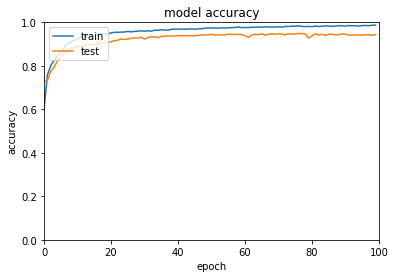

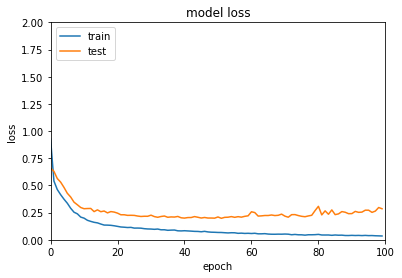

,walk,up,down,sit,stand,lay
walk,456,7,33,0,0,0
up,13,454,4,0,0,0
down,2,1,417,0,0,0
sit,0,5,0,419,63,4
stand,1,0,0,31,500,0
lay,0,0,0,0,0,537


In [108]:
performance_plots(model, X_test, Y_test, log, n_epochs)
confusion_matrix(model, X_test, Y_test)

#### Findings

Using a two dimensional CNN with kernel strictly applied only in the time dimension and reshaping the input in a way such that the channel dimension corresponds to the spatial one (x, y, z) seems to be superior to the other approaches with a max test accuracy of 94.9%. This network can be interpreted as an ensemble of 1D CNN's, one for each sensor and its measurements.